## Assignment 1
### Name: Anuguru Parthiv Reddy
### Roll Number: 21CS10006

In [34]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz
import graphviz
from IPython.display import Image
from collections import deque

df = pd.read_csv('/decision-tree.csv')
print(df.shape)
df.head()

# Splitting the dataset into features (x_data) and target labels (y_data)
x_data = df.iloc[:, :-1]
y_data = df.iloc[:, -1]

# Splitting the data into train, validation, and test sets
x_train, x_rem, y_train, y_rem = train_test_split(x_data, y_data, train_size=0.7,random_state=42)       # 70% for training
x_val, x_test, y_val, y_test = train_test_split(x_rem, y_rem, train_size=0.5,random_state=42)           # 50% of remaining data for validation

# Resetting and dropping the index column for consistency in data handling
x_train = x_train.reset_index()
y_train = y_train.reset_index()
x_val = x_val.reset_index()
y_val = y_val.reset_index()
x_train = x_train.drop(['index'], axis=1)
y_train = y_train.drop(['index'], axis=1)
x_val = x_val.drop(['index'], axis=1)
y_val = y_val.drop(['index'], axis=1)
y_val = y_val.iloc[:, 0]  # Extracting the Series from DataFrame


class TreeNode:
    def __init__(self, data, target, features,parent,depth):
        self.data = data
        self.target = target
        self.features = features
        self.parent=parent
        self.attribute = None
        self.left = None
        self.best_split = None
        self.right = None
        self.depth=depth
        if (target == 0).sum() >= (target == 1).sum():
            self.label = 0
        else:
            self.label = 1

def entropy(pos,neg):
    if(pos==0 or neg==0):
        return 0
    else:
        p=pos/(pos+neg)
        n=neg/(pos+neg)
        return -(p*math.log(p,2)+n*math.log(n,2))

def info_gain(x_data,y_data, target, split_point):
    posl=((x_data[target] < split_point) & (y_data == 1)).sum()
    negl=((x_data[target] < split_point) & (y_data == 0)).sum()
    cntl=negl+posl
    posr=((x_data[target] >= split_point) & (y_data == 1)).sum()
    negr=((x_data[target] >= split_point) & (y_data == 0)).sum()
    cntr=negr+posr
    if(cntl+cntr==0):
        return 0
    childentropy=(cntl/(cntl+cntr))*entropy(posl,negl)+(cntr/(cntl+cntr))*entropy(posr,negr)
    return entropy(posl+posr,negl+negr)-childentropy

def bestfeature(x_data,y_data,features):
    bfeat=None
    bsplit=None
    maxinfo=0.0
    for feature in features:
        unique_values = sorted(x_data[feature].unique())
        for i in range(len(unique_values)):
            if(i!=0):
                val=(unique_values[i]+unique_values[i-1])/2
                temp=info_gain(x_data,y_data,feature,val)
                if (temp>maxinfo):
                    bfeat=feature
                    bsplit=val
                    maxinfo=temp
    return bfeat,bsplit

def ID3_tree(x_data, y_data, features, val_data, val_target,parent=None,depth=0):
    node = TreeNode(x_data, y_data, features,parent,depth)
    best_attribute, best_split = bestfeature(x_data,y_data,features)
    node.best_split = best_split

    if (y_data.nunique() == 1):
        node.label = y_data.iloc[0]
        return node

    if len(features) == 0 or len(y_data) < 10 :
        node.label = y_data.value_counts().idxmax()  # Assign label directly
        return node

    if best_attribute is None:
        node.label = y_data.value_counts().idxmax()  # Assign label directly
        return node

    node.attribute = best_attribute
    subleft = x_data[x_data[best_attribute] < best_split]
    subright = x_data[x_data[best_attribute] >= best_split]
    new_features = features.drop(best_attribute)  # Update features for the next recursive call

    node.left = ID3_tree(subleft, y_data[x_data[best_attribute] < best_split], new_features, val_data, val_target, node,depth+1)
    node.right = ID3_tree(subright, y_data[x_data[best_attribute] >= best_split], new_features, val_data, val_target, node,depth+1)

    return node

tree_root = ID3_tree(x_train, y_train['Outcome'], x_train.columns, x_val, y_val)


def measure_performance(tree_root, x_val, y_val):
    # Initialize lists to store predictions and actual labels
    predictions = []
    actual_labels = y_val.tolist()

    # Make predictions for each sample in x_val using the decision tree
    for _, sample in x_val.iterrows():
        current_node = tree_root

        # Traverse the decision tree until a leaf node is reached
        while current_node.attribute is not None:
            if sample[current_node.attribute] < current_node.best_split:
                current_node = current_node.left
            else:
                current_node = current_node.right

        # Append the predicted label for the current sample
        predictions.append(current_node.label)

    accuracy = accuracy_score(actual_labels, predictions)
    precision = precision_score(actual_labels, predictions, average='macro',zero_division=0)
    recall = recall_score(actual_labels, predictions, average='macro')

    # Return the metrics as a dictionary
    metrics = {
        'Accuracy': accuracy,
        'Macro Precision': precision,
        'Macro Recall': recall
    }

    return metrics

def prune_tree(tree_root, x_val, y_val):
    if tree_root is None:
        return
    #first we add nodes using to queue bfs level wise
    bfs = deque([(tree_root, None)])
    queue = deque([(tree_root, None)])
    while bfs:
        node,parent=bfs.popleft()
        if(node.attribute is None):
            continue
        if node.left is not None:
            bfs.append((node.left, node))
            queue.append((node.left, node))
        if node.right is not None:
            bfs.append((node.right, node))
            queue.append((node.right, node))

    #depth and accuracy arrays are to draw graph where there can be multiple points at same depth
    #Reason: multiple nodes can be pruned at same depth giving different accuracy
    depth=np.array([],dtype=int)
    accuracy=np.array([],dtype=float)

    #we can start from parents of leaves which are at the rightend of queue
    while queue:
        node,parent=queue.pop()
        original_attribute = node.attribute
        original_left = node.left
        original_right = node.right
        #performance it node is not pruned
        pre_perf=measure_performance(tree_root, x_val, y_val)['Accuracy']
        node.attribute=None
        node.left=None
        node.right=None
        #performance if node is pruned
        aft_perf=measure_performance(tree_root, x_val, y_val)['Accuracy']
        if(aft_perf>=pre_perf):
            #if perf after pruning increased we leave node.attribute,left,right as None
            #elese we don't prune so we update those None values with their original value
            depth=np.append(depth,node.depth)
            accuracy=np.append(accuracy,aft_perf)
            continue
        else:
            node.attribute=original_attribute
            node.left=original_left
            node.right=original_right
    #plotting the depth vs accuracy graph
    plt.scatter(depth,accuracy)
    plt.xlabel('Depth')
    plt.ylabel('Accuracy')
    plt.title('Depth vs Accuracy')
    plt.show()

#we are building tree edges in graphviz by simple traversal
def export_tree_to_dot(node, dot, parent=None):
    if node is None:
        return
    if node.attribute is not None:
        dot.node(str(id(node)), f"{node.attribute}\nSplit Value: {node.best_split}")
    else:
        dot.node(str(id(node)), f"Label: {node.label}", shape='box')
    if parent is not None:
        dot.edge(str(id(parent)), str(id(node)))

    export_tree_to_dot(node.left, dot, node)
    export_tree_to_dot(node.right, dot, node)

print("BEFORE PRUNING=======")

dot = graphviz.Digraph(comment='Custom Decision Tree')
export_tree_to_dot(tree_root, dot)

dot.format = 'png'
dot.render('before_prune')

print("Validation Data:")
performance_metrics = measure_performance(tree_root, x_val, y_val)

for metric_name, metric_value in performance_metrics.items():
    print(f"{metric_name}: {metric_value}")

print("Test Data:")
performance_metrics = measure_performance(tree_root, x_test, y_test)

for metric_name, metric_value in performance_metrics.items():
    print(f"{metric_name}: {metric_value}")


(768, 9)
BEFORE PRUNING=======
Validation Data:
Accuracy: 0.6956521739130435
Macro Precision: 0.6591650358773646
Macro Recall: 0.6690921690921692
Test Data:
Accuracy: 0.6982758620689655
Macro Precision: 0.6813725490196079
Macro Recall: 0.6885950939789742


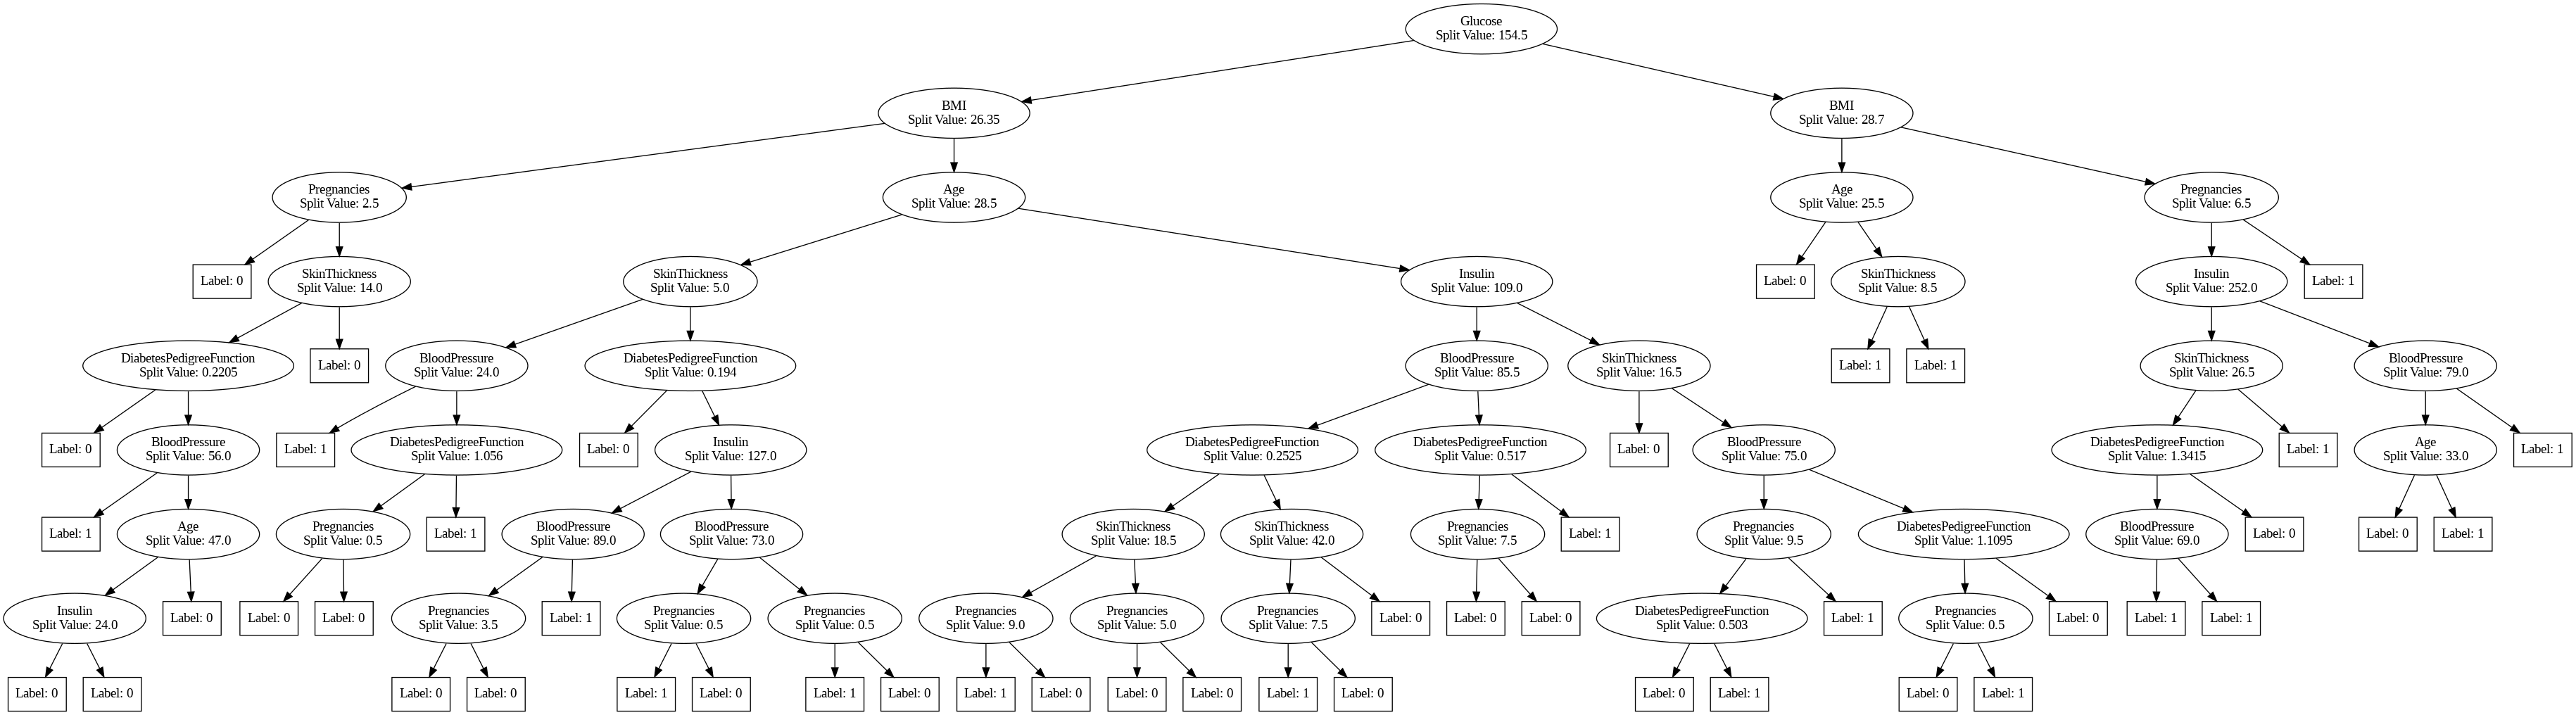

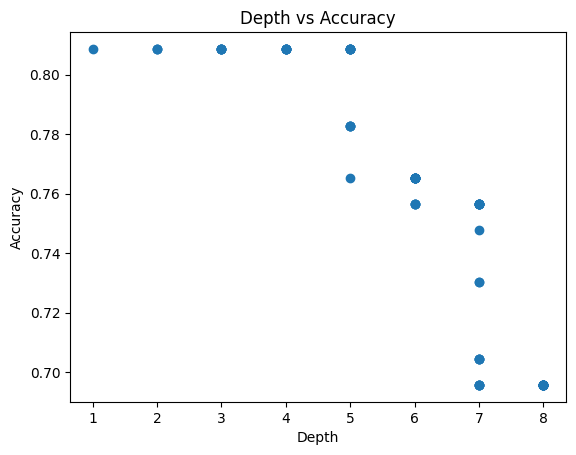

AFTER PRUNING=========
Validation Data:
Accuracy: 0.808695652173913
Macro Precision: 0.7876344086021505
Macro Recall: 0.7595287595287595
Test Data:
Accuracy: 0.7327586206896551
Macro Precision: 0.726461038961039
Macro Recall: 0.6777636189869385


In [35]:
# Perform pruning on your decision tree
prune_tree(tree_root, x_val, y_val)

dot = graphviz.Digraph(comment='Custom Decision Tree')
export_tree_to_dot(tree_root, dot)

dot.format = 'png'
dot.render('after_prune')

print("AFTER PRUNING=========")
print("Validation Data:")
performance_metrics = measure_performance(tree_root, x_val, y_val)

for metric_name, metric_value in performance_metrics.items():
    print(f"{metric_name}: {metric_value}")

print("Test Data:")
performance_metrics = measure_performance(tree_root, x_test, y_test)

for metric_name, metric_value in performance_metrics.items():
    print(f"{metric_name}: {metric_value}")

Note that accuracy of validation and test both increased after pruning the tree. And observe how overfitting and unnecessary nodes are removed using pruning.

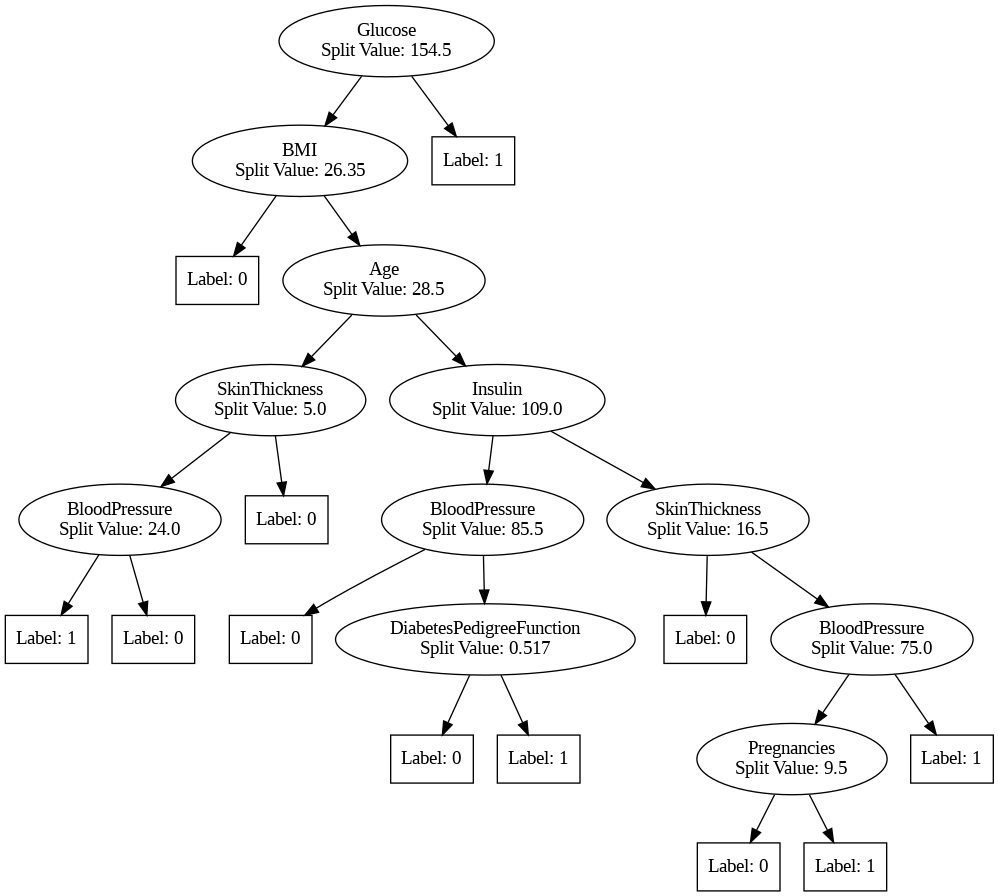